In [70]:
import json
import csv
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
from tqdm import tqdm
# import os
# import re
# from time import sleep
# from concurrent.futures import ThreadPoolExecutor
# from parallelplot import parallel_plot
# from concurrent.futures import ProcessPoolExecutor
# from multiprocessing import Pool
from joblib import Parallel, delayed
import multiprocessing
from matplotlib.animation import FuncAnimation
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

In [93]:
# path=r"Runs\Low Density\LD1MPI2/"
# path=r"Runs\Low Density\LD10MP06/"
# path=r"Runs\Mid Density\MD1MPI2/"
path=r"Runs\High Density\HD1MPI04/"

# Load Parameters & Data

In [94]:
def save_param(csv_file_path=path+"params.csv"):
    # Open the CSV file
    with open(csv_file_path, mode='r') as infile:
        reader = csv.reader(infile)
        mydict = {rows[0]:rows[1] for rows in reader}
    return mydict

variable_dict=save_param()

r=float(variable_dict["sigma"])/2.0
numParticles=int(variable_dict["numParticles"])
box_size=float(variable_dict["boxSize"])
numSteps=int(variable_dict["numSteps"])
timestep=float(variable_dict["timestep"])
dataCompression=int(variable_dict["dataCompression"])
try : theta=(float(variable_dict["theta"])*(180.0/math.pi))
except : theta=(variable_dict["theta"]) 

def load_data(path):
    with open(path+'particle_positions.json', 'r') as file:
        data = json.load(file)
    return data

data = load_data(path)
# Convert the data to a NumPy array
particle_positions = np.array(load_data(path))

print(variable_dict)

{'comment': 'Checking the latest autocorection formula by sir at Pi/4', 'epsilon': '1', 'sigma': '1', 'numParticles': '625', 'boxSize': '30', 'temperature': '1', 'cutoff': '1.12246', 'my_gamma': '100', 'timestep': '0.001', 'numSteps': '1000000', 'dataCompression': '5000', 'period': '100', 'NoOfPeriods': '1000', 'theta': '0.785398', 'R_0': '1.5', 'D_R': '0.08', 'D_T': '0.01', 'Pe': '0', 'v_0': '1', 'Omega': '4.8'}


# Plot Energy

In [312]:
def energy_plotly_plotter(xlabel, ylabel, legend_names, colors):
    time = []
    kinetic_energy = []
    potential_energy = []
    total_energy = []

    for t in range(len(particle_positions)):
        time.append(float(t)*dataCompression*timestep)
        kinetic_energy_total=0.0
        i=0
        for _, _ ,vx ,vy , _, PE in particle_positions[t]:
            kinetic_energy_total+=(float(0.5 * (vx**2 + vy**2)))
            if i==len(particle_positions[0])-1:
                potential_energy_per_particle=float(PE)
                kinetic_energy_per_particle=kinetic_energy_total/float(len(particle_positions[0]))
            i+=1
        potential_energy.append(potential_energy_per_particle)
        kinetic_energy.append(kinetic_energy_per_particle)
        total_energy.append(potential_energy_per_particle+kinetic_energy_per_particle)
    # Create Plotly figure
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=time, y=kinetic_energy, mode='lines', name=legend_names[0], line=dict(color=colors[0])))
    fig.add_trace(go.Scatter(x=time, y=potential_energy, mode='lines', name=legend_names[1], line=dict(color=colors[1])))
    fig.add_trace(go.Scatter(x=time, y=total_energy, mode='lines', name=legend_names[2], line=dict(color=colors[2])))

    fig.update_layout(title="Energy Plot", xaxis_title=xlabel, yaxis_title=ylabel, width=1200, height=600)

    pio.write_html(fig, path+'tempi.html')
    fig.show()
legend_names = ["Kinetic Energy", "Potential Energy", "Total Energy"]
colors = ['blue', 'green', 'red']
energy_plotly_plotter("Time", "Energy per Particle", legend_names, colors)

In [5]:
# Auto-refreahing Plot
# f=0
# legend_names = ["Kinetic Energy", "Potential Energy", "Total Energy"]
# colors = ['blue', 'green', 'red']
# while True:
#         energy_plotly_plotter("Time", "Energy per Particle", legend_names, colors)
#         if f<1:
#             os.system(f"start {os.getcwd()}/tempi.html")
#         f+=1
        # sleep(10) #change to increase delay

# Final Frame Plotter

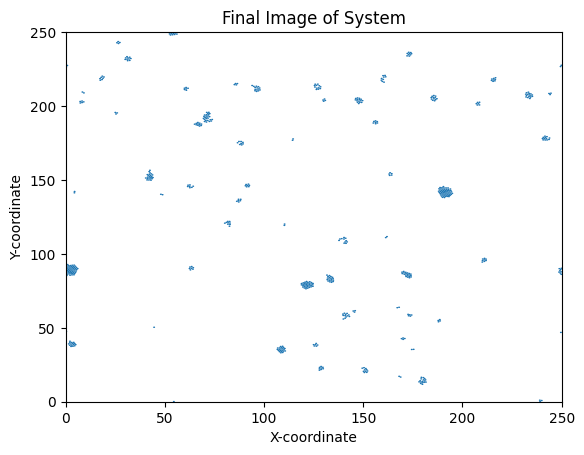

In [35]:
def FinalSysImagePlotter():
    # Create a figure and axis for the Plot
    fig, ax = plt.subplots()
    ax.set_xlim(0, box_size)
    ax.set_ylim(0, box_size)
    
    for x, y ,vx ,vy , phi, PE in particle_positions[-1]:
        circle = plt.Circle((x, y), radius=r, linewidth=0)
        ax.add_patch(circle)
    
    # Add an arrow to represent the direction of movement
        # arrow = plt.Arrow(x, y, vx, vy, width=0.1, color='black')
        # ax.add_patch(arrow)
        
    # Add an arrow to represent the vision direction
        # arrow = plt.Arrow(x, y, np.cos(phi), np.sin(phi), width=0.1, color='orange')
        # ax.add_patch(arrow)
    
    # Set axis labels and title
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.title('Final Image of System')
    
    # Show the plot
    plt.savefig(path+"FinalFrame.png")

#Plots the final system image
FinalSysImagePlotter()

# Animation

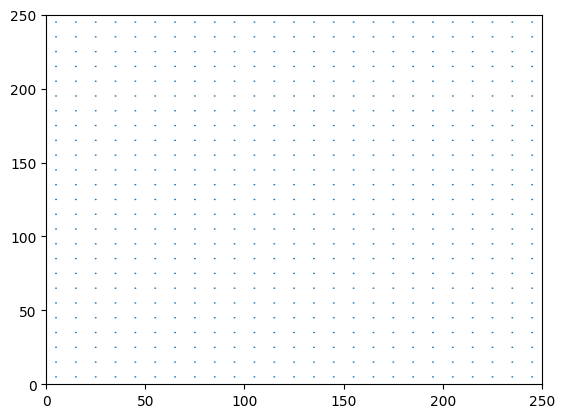

In [212]:
fig, ax = plt.subplots()
def update(frame):

# Function to update the animation
    ax.clear()
    ax.set_xlim(0, box_size)
    ax.set_ylim(0, box_size)

    # Plot the particles at the given frame as circles
    for x, y , vx, vy, phi, _ in particle_positions[frame]:
        circle = plt.Circle((x, y), radius=r, linewidth=0)
        ax.add_patch(circle)

# Create the animation
animation = FuncAnimation(fig, update, frames=len(particle_positions), interval=100)

# Save the animation as a GIF or a video
# animation.save(path+'particle_animation.gif', writer='pillow')  # For GIF
animation.save(path+'particle_animation.mp4', writer='ffmpeg')  # For MP4


In [6]:
def min_image_convention(dx, box_size):
    # Apply minimum image convention to get the shortest distance
    if dx > box_size / 2:
        dx -= box_size
    elif dx < -box_size / 2:
        dx += box_size
    return dx

  4%|▍         | 24/625 [00:20<00:03, 185.72it/s]

# Mean Squared Displacement

In [21]:
def MSD(Datain):
    data=Datain
    # Create an empty lists to store the "MSD list", average MSD per gap and standard deviation of those MSD
    MSDPerParticle = [[0.0] * int(math.floor(len(data) - 1.0)) for i in range(numParticles)]
    averageMSDPerGap = [0.0] * math.floor(len(data) -1.0)
    stdMSDPerGap = [0.0] * math.floor(len(data) -1.0)

    # Create a nested for-loop running through each particle all the possible gap values to create the MSD Matrix
    for i in   tqdm(range(numParticles)):
        for j in range(math.floor(len(data) -1.0)):
            for k in range(len(data) - j - 1):
                dx = float(data[k+j+1][i][0]) - float(data[k][i][0])
                dy = float(data[k+j+1][i][1]) - float(data[k][i][1])
                # Apply periodic boundary conditions
                dx = min_image_convention(dx, box_size)
                dy = min_image_convention(dy, box_size)
                MSDPerParticle[i][j] += dx*dx + dy*dy
            MSDPerParticle[i][j] /= (len(data) - j - 1)

    # Create a for loop running through half the size of the number of timesteps; here j will be called "gap"
    for j in range(math.floor(len(data)-1.0)):
        MSDValues = []
        for i in range(numParticles):
            # Add the MSD of each particle at a given gap to the list
            MSDValues.append(MSDPerParticle[i][j])

        # Calculate the mean and standard deviation of the MSD values
        averageMSDPerGap[j] = np.mean(MSDValues)
        stdMSDPerGap[j] = np.std(MSDValues)
    x=[i*dataCompression*timestep for i in range(math.floor(len(data)-1.0))]
    y=averageMSDPerGap
    dy=stdMSDPerGap
    return x, y, dy
# x,y,dy=MSD(data)

In [81]:
def plot_MSD(x,y, theta, path):
    # def func(v, m, c):
    #     return m * np.array(v) + c
    # popt, pcov = curve_fit(func, x, y)
    cmap = plt.get_cmap('rainbow')  # You can choose a different colormap
    color = cmap(int(theta)/180)  # Use theta to get a unique color from the colormap
    plt.plot(x, y, label=f'Vission angle \u03B8={round(theta)}\u00B0',color=color)
    # plt.plot(x, func(x, *popt), label=f'fit - VC={round(theta)}', color=color)
    plt.yscale('log')
    plt.xscale('log')
    plt.xticks(fontsize=8)
    plt.xticks(fontsize=8)
    plt.grid(True)
    plt.xlabel("Time Gap")
    plt.ylabel("MSD")
    plt.legend() 
    # plt.title("Mean Squared Displacement")
    plt.savefig(path+"MSD.png")

# plot_MSD(x,y, dy, path)

# Auto-Correlation Function

100%|██████████| 199/199 [00:00<00:00, 10639.20it/s]


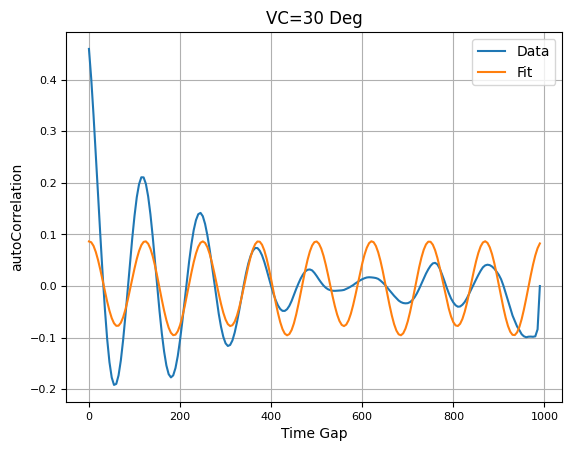

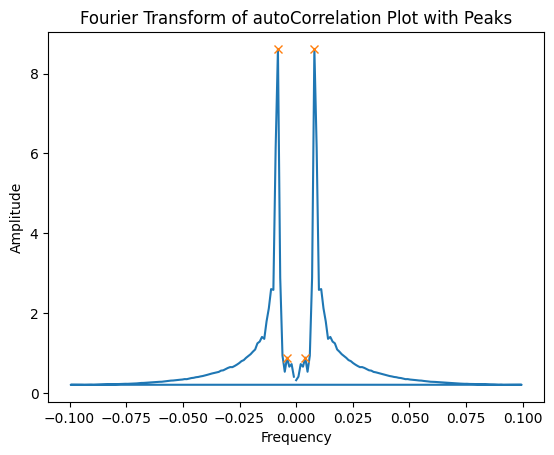

In [234]:
def autoCorrelation():

    # Create an empty list to store the "autoCorrelation list", average autoCorrelation per gap and standard deviation of those autoCorrelation
    autoCorrelationPerParticle = [[0.0] * int(math.floor(len(data) - 1.0)) for i in range(numParticles)]
    averageAutoCorrelationPerGap = [0.0] * math.floor(len(data) -1.0)
    stdAutoCorrelationPerGap = [0.0] * math.floor(len(data) -1.0)

    # Create a nested for-loop running through each particle all the possible gap values to create the autoCorrelation Matrix; here j will be called "gap"
    for i in tqdm(range(numParticles)):
        for j in range(math.floor(len(data) -2.0)):
            for k in range(len(data) - j - 2):
                cos1=min_image_convention((data[k+1][i][0] - data[k][i][0]), box_size) / math.sqrt(min_image_convention((data[k+1][i][0] - data[k][i][0]), box_size) ** 2 + min_image_convention((data[k+1][i][1] - data[k][i][1]), box_size) ** 2)
                cos2=min_image_convention((data[k+j+2][i][0] - data[k+j+1][i][0]), box_size) / math.sqrt(min_image_convention((data[k+j+2][i][0] - data[k+j+1][i][0]), box_size) ** 2 + min_image_convention((data[k+j+2][i][1] - data[k+j+1][i][1]), box_size) ** 2)
                autoCorrelationPerParticle[i][j] += cos1 * cos2 
            autoCorrelationPerParticle[i][j] /= (len(data) - j - 2)

    # Create a for loop running throughall possible gap values
    for j in tqdm(range(math.floor(len(data)-1.0))):
        autoCorrelationValues = []
        for i in range(numParticles):
            # Add the autoCorrelation of each particle at a given gap to the list
            autoCorrelationValues.append(autoCorrelationPerParticle[i][j])

        # Calculate the mean and standard deviation of the autoCorrelation values
        averageAutoCorrelationPerGap[j] = np.mean(autoCorrelationValues)
        stdAutoCorrelationPerGap[j] = np.std(autoCorrelationValues)

    # Calculate the Fourier transform of the autoCorrelation data and Find the peaks in the Fourier transform
    fft = np.fft.fft(averageAutoCorrelationPerGap)
    freq = np.fft.fftfreq(len(averageAutoCorrelationPerGap), d=(dataCompression*timestep))
    peaks, properties = find_peaks(np.abs(fft), prominence=(0.2, None))

    #  Create a new frequency spectrum with zeros everywhere and set the values at the major peak indices to the original complex amplitudes
    new_fft = np.zeros_like(fft)
    new_fft[peaks] = fft[peaks]
    # Perform Inverse Fourier Transform of the new frequency spectrum to get the reconstructed signal
    reconstructed_signal = np.fft.ifft(new_fft)

    # Fit the averageautoCorrelationPerGap data using the peak frequencies in the autoCorrelation plot
    plt.plot([i*dataCompression*timestep for i in range(math.floor(len(data)-1.0))], averageAutoCorrelationPerGap, label='Data')
    # plt.errorbar([i*dataCompression*timestep for i in range(math.floor(len(data)-1.0))], averageAutoCorrelationPerGap, yerr=stdAutoCorrelationPerGap, ecolor = 'lightblue', capsize=0, label='Data')
    plt.plot([i*dataCompression*timestep for i in range(math.floor(len(data)-1.0))], reconstructed_signal, label='Fit')
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.grid()
    plt.xlabel("Time Gap")
    plt.ylabel("autoCorrelation")
    plt.legend()
    if type(theta) == float: plt.title("VC=" + str(round(theta))+" Deg")
    else: plt.title("VC=" + str(theta))
    plt.savefig(path+"autoCorrelation.png")
    
    #Plot the Fourier transform
    fig, ax = plt.subplots()
    ax.plot(freq, np.abs(fft))
    ax.plot(freq[peaks], np.abs(fft)[peaks], "x")
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Amplitude')
    ax.set_title('Fourier Transform of autoCorrelation Plot with Peaks')
    plt.savefig(path+"autoCorrelation_fft.png")
    

autoCorrelation()

In [64]:
def autoCorrelation3():

    # Create an empty list to store the "autoCorrelation list", average autoCorrelation per gap and standard deviation of those autoCorrelation
    autoCorrelationPerParticle = [[0.0] * int(math.floor(len(data) - 1.0)) for i in range(numParticles)]
    averageAutoCorrelationPerGap = [0.0] * math.floor(len(data) -1.0)
    stdAutoCorrelationPerGap = [0.0] * math.floor(len(data) -1.0)

    # Create a nested for-loop running through each particle, all the possible gap values to create the autoCorrelation Matrix; here j will be called "gap"
    for i in tqdm(range(numParticles)):
        for j in range(len(data) -1):
            for k in range(len(data) - j - 2):
                d1x = min_image_convention(data[k + 1][i][0] - data[k][i][0], box_size)
                d1y = min_image_convention(data[k + 1][i][1] - data[k][i][1], box_size)
                d1norm = math.sqrt(d1x**2 + d1y**2)

                d2x = min_image_convention(data[k + j + 2][i][0] - data[k + j + 1][i][0], box_size)
                d2y = min_image_convention(data[k + j + 2][i][1] - data[k + j + 1][i][1], box_size)
                d2norm = math.sqrt(d2x**2 + d2y**2) 
                autoCorrelationPerParticle[i][j] += (d1x * d2x + d1y * d2y)/(d1norm*d2norm)
            autoCorrelationPerParticle[i][j]/=(len(data) - j - 1)

    # Create a for loop running throughall possible gap values
    for j in tqdm(range(len(data)-1)):
        autoCorrelationValues = []
        for i in range(numParticles):
            # Add the autoCorrelation of each particle at a given gap to the list
            autoCorrelationValues.append(autoCorrelationPerParticle[i][j])

        # Calculate the mean and standard deviation of the autoCorrelation values
        averageAutoCorrelationPerGap[j] = np.mean(autoCorrelationValues)
        stdAutoCorrelationPerGap[j] = np.std(autoCorrelationValues)
    x=[i*dataCompression*timestep for i in range(math.floor(len(data)-2))]
    y=averageAutoCorrelationPerGap[:len(x)]
    dy=stdAutoCorrelationPerGap[:len(x)]
    return x, y, dy

x, y, dy=autoCorrelation3()

100%|██████████| 199/199 [00:00<00:00, 14804.83it/s]


In [68]:
def autocorrelation_for_particle(i, data, box_size):
    result = np.zeros(len(data) - 1)
    for j in range(len(data) - 1):
        for k in range(len(data) - j - 2):
            d1x = min_image_convention(data[k + 1][i][0] - data[k][i][0], box_size)
            d1y = min_image_convention(data[k + 1][i][1] - data[k][i][1], box_size)
            d1norm = math.sqrt(d1x**2 + d1y**2)

            d2x = min_image_convention(data[k + j + 2][i][0] - data[k + j + 1][i][0], box_size)
            d2y = min_image_convention(data[k + j + 2][i][1] - data[k + j + 1][i][1], box_size)
            d2norm = math.sqrt(d2x**2 + d2y**2)
            
            result[j] += (d1x * d2x + d1y * d2y)/(d1norm*d2norm)
        result[j]/=(len(data) - j - 1)
    return result

def autoCorrelation3_parallel(data, box_size, numParticles):
    autoCorrelationPerParticle = Parallel(n_jobs=-1)(delayed(autocorrelation_for_particle)(i, data, box_size) for i in tqdm(range(numParticles)))
    autoCorrelationPerParticle = np.array(autoCorrelationPerParticle)

    averageAutoCorrelationPerGap = np.mean(autoCorrelationPerParticle, axis=0)
    stdAutoCorrelationPerGap = np.std(autoCorrelationPerParticle, axis=0)

    x = [i * dataCompression * timestep for i in range(math.floor(len(data) - 2))]
    y = averageAutoCorrelationPerGap[:len(x)]
    dy = stdAutoCorrelationPerGap[:len(x)]

    return x, y, dy

# Example usage
x, y, dy = autoCorrelation3_parallel(data, box_size, numParticles)

100%|██████████| 625/625 [06:53<00:00,  1.51it/s]


[]
[9.58934645e-01 1.63048889e+03 7.78425115e+01 2.32550858e+03]


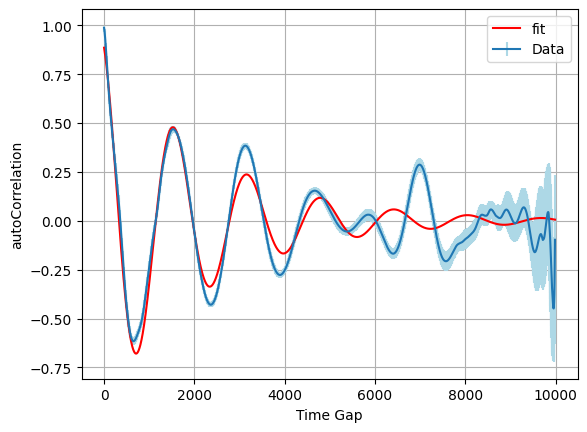

In [69]:
def plot_AutoCorrelation3(x,y, dy):
    # Calculate the Fourier transform of the autoCorrelation data and Find the peaks in the Fourier transform
    fft = np.fft.fft(x)
    freq = np.fft.fftfreq(len(x), d=(dataCompression*timestep))
    peaks, properties = find_peaks(np.abs(fft), prominence=(10.0, None))
    print(2*math.pi/freq[peaks])

    # fit the curve with a sinusoidal decaying exponential
    def func(p, a, b, c, d):
        return  a*np.cos(2*math.pi * (np.array(p)+c)/b)*np.exp(- (np.array(p)+c)/d)
    # plot the fitted curve
    popt, pcov = curve_fit(func, x, y, p0=[1.0, 100, 1.0,100])
    print(popt)
    
    # Fit the averageautoCorrelationPerGap data using the peak frequencies in the autoCorrelation plot
    # plt.plot(x, y, label='Data')
    plt.errorbar(x,y, yerr=dy, ecolor = 'lightblue', capsize=0, label='Data')
    plt.plot(x, func (x, *popt), 'r-', label='fit')
    # plt.text(0.1, 0.1, "Fit values"+"\na="+str(round(popt[0], 2))+"\nb="+str(round(popt[1], 2))+"\nc="+str(round(popt[2], 2))+"\nc="+str(round(popt[3], 2)), fontsize=8, horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)
    plt.grid()
    plt.xlabel("Time Gap")
    plt.ylabel("autoCorrelation")
    plt.legend()
    # if type(theta) == float: plt.title("VC=" + str(round(theta))+" Deg")
    # else: plt.title("VC=" + str(theta))
    plt.savefig(path+"autoCorrelation3.png")

plot_AutoCorrelation3(x,y, dy)

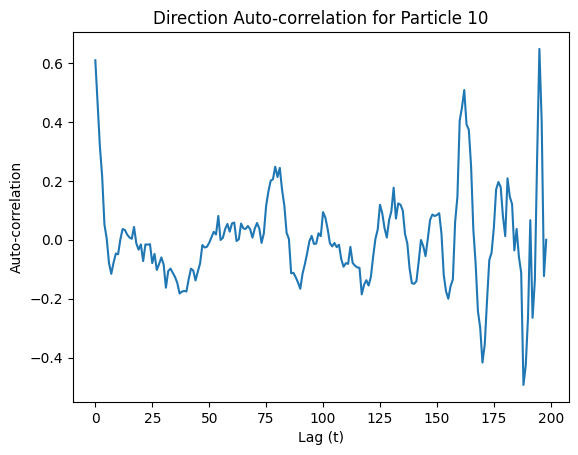

In [99]:
def autoCorrelationOneParticle(particle_index, data):
    numFrames = len(data)
    autoCorrelationValues = []

    for lag in range(1, numFrames):
        autoCorrelation = 0.0

        for t in range(numFrames - lag-1):
            # Extracting direction vectors for the specified particle
            n1 = np.array(data[t][particle_index][0:2]) - np.array(data[t + 1][particle_index][0:2])
            n2 = np.array(data[t + lag][particle_index][0:2]) - np.array(data[t + lag + 1][particle_index][0:2])


            # Normalizing direction vectors
            n1 /= np.linalg.norm(n1)
            n2 /= np.linalg.norm(n2)

            # Calculating the dot product
            dot_product = np.dot(n1, n2)
            autoCorrelation += dot_product

        autoCorrelation /= (numFrames - lag)
        autoCorrelationValues.append(autoCorrelation)

    return autoCorrelationValues

# Example usage:
particle_index = 10  # Replace with the index of the particle you want to analyze
result = autoCorrelationOneParticle(particle_index, data)

# Plotting the result
plt.plot(result)
plt.xlabel("Lag (t)")
plt.ylabel("Auto-correlation")
plt.title(f"Direction Auto-correlation for Particle {particle_index}")
plt.show()

# Persistence

In [98]:
def persistence(datain):
    data=datain
    size=len(data)
    # Create an empty list to store the "Persistence list" and  average persistence per gap
    persistencePerParticle = [[0.0] * (size) for i in range(numParticles)]
    averagePersistencePerGap = [0.0] * (size)
    # Create a nested for-loop running through each particle all the possible gap values to create the Persistence Matrix; here j will be called "gap"
    for i in tqdm(range(numParticles)):
        for j in range(size):
            for k in range(size - j-1):#-1 cuz we want to avoid the last particle bcause there is no k+1 for it
                flag=0
                d1x = min_image_convention((data[k + 1][i][0] - data[k][i][0]), box_size)
                d1y = min_image_convention((data[k + 1][i][1] - data[k][i][1]), box_size)
                d1norm = math.sqrt(d1x**2 + d1y**2)
                for l in range (j+1):
                    d2x = min_image_convention((data[k+l+1][i][0] - data[k+l][i][0]), box_size)
                    d2y = min_image_convention((data[k+l+1][i][1] - data[k+l][i][1]), box_size)
                    d2norm = math.sqrt(d2x**2 + d2y**2)
                    if (d1x * d2x + d1y * d2y)/(d1norm*d2norm)<0: #if cos becomes negative
                        flag=1
                        break
                if flag==0:persistencePerParticle[i][j] += 1.0
            persistencePerParticle[i][j] /= int(size - j)

    # Create a for loop running through persistencePerParticle[i] and finding the mean persistence
    for j in tqdm(range(size)):
        persistenceValues = []
        for i in range(numParticles):
            # Add the persistence of each particle at a given gap to the list
            persistenceValues.append(persistencePerParticle[i][j])

        # Calculate the mean  of the persistence values
        averagePersistencePerGap[j] = np.mean(persistenceValues)

    x = [i*dataCompression*timestep for i in range(size-1)]
    y = averagePersistencePerGap[:len(x)]
    
    return y, x

y, x=persistence(data)

100%|██████████| 200/200 [00:00<00:00, 16216.76it/s]


In [97]:
def calculate_persistence(i, data, size, numParticles, box_size):
    persistenceValues = []
    for j in range(size):
        for k in range(size - j - 1):
            flag = 0
            d1x = min_image_convention((data[k + 1][i][0] - data[k][i][0]), box_size)
            d1y = min_image_convention((data[k + 1][i][1] - data[k][i][1]), box_size)
            d1norm = math.sqrt(d1x**2 + d1y**2)
            for l in range(j + 1):
                d2x = min_image_convention((data[k + l + 1][i][0] - data[k + l][i][0]), box_size)
                d2y = min_image_convention((data[k + l + 1][i][1] - data[k + l][i][1]), box_size)
                d2norm = math.sqrt(d2x**2 + d2y**2)
                if (d1x * d2x + d1y * d2y) / (d1norm * d2norm) < 0:  # if cos becomes negative
                    flag = 1
                    break
            if flag == 0:
                persistenceValues.append(1.0)
            else:
                persistenceValues.append(0.0)
    return i, persistenceValues

def parallel_persistence(data):
    size = len(data)
    num_cores = multiprocessing.cpu_count()

    results = Parallel(n_jobs=num_cores)(delayed(calculate_persistence)(i, data, size, numParticles, box_size) for i in tqdm(range(numParticles)))

    persistencePerParticle = [[0.0] * size for _ in range(numParticles)]

    for i, persistenceValues in results:
        for j, value in enumerate(persistenceValues):
            persistencePerParticle[i][j] = value

    averagePersistencePerGap = [np.mean([persistencePerParticle[i][j] for i in range(numParticles)]) for j in tqdm(range(size))]

    x = [i * dataCompression * timestep for i in range(size - 1)]
    y = averagePersistencePerGap[:len(x)]

    return y, x

y, x = parallel_persistence(data)


100%|██████████| 625/625 [00:28<00:00, 21.69it/s]


IndexError: list assignment index out of range

[ 1.15885993  0.0160065  -0.0038008 ]


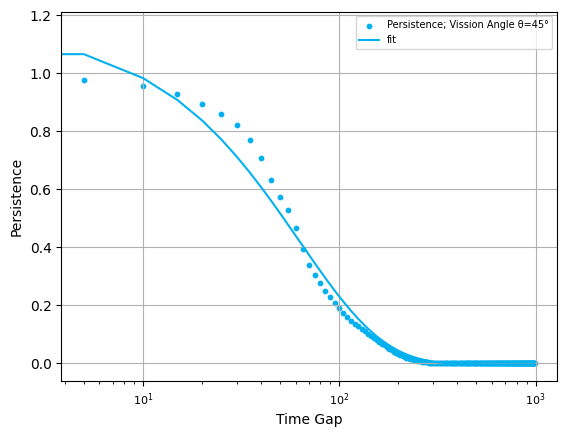

In [102]:
def plot_persistence(x, y, theta, save_path):
    #fit and plot the data with an exponential function and print the fit values
    def func(v, a, b, c):
        return a * np.exp(-b * np.array(v)) + c
    #fit and plot the data with an Sigmoid function and print the fit values
    # def func(v, a, c):
    #     return -1 / (1 + np.exp(-(a * np.array(v) - c))) + 1
    popt, pcov = curve_fit(func, x, y, p0=[1, 0.01, 0])
    print (popt)
    #save the fit parameters to the plot
    cmap = plt.get_cmap('rainbow')  # You can choose a different colormap
    color = cmap(int(theta)/180)  # Use theta to get a unique color from the colormap
    
    plt.scatter(x, y, label=f'Persistence; Vission Angle \u03B8={round(theta)}\u00B0', marker='o', color=color, s=10)
    plt.plot(x, func(x, *popt), label=f'fit', color=color)
    # plt.yscale('log', base=2)
    plt.xscale('log')
    #increase font size of x axis title
    plt.xticks(fontsize=8)
    plt.xticks(fontsize=8)
    plt.grid(True)
    plt.xlabel("Time Gap")
    plt.ylabel("Persistence")
    # if type(theta) == float: plt.title("VC=" + str(round(theta))+" Deg")
    # else: plt.title("VC=" + str(theta))
    plt.legend(fontsize=7)
    # plt.text(0.1, 0.1, "Fit values"+"\na="+str(round(popt[0], 2))+"\nb="+str(round(popt[1], 2))+"\nc="+str(round(popt[2], 2)), fontsize=8, horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)
    plt.savefig(save_path+"persistence.png")
plot_persistence(x, y, theta, path)

100%|██████████| 200/200 [00:00<00:00, 18142.63it/s]


[ 2.89560800e+00  1.39835882e-03 -1.89133354e+00]


100%|██████████| 200/200 [00:00<00:00, 15677.30it/s]


[ 1.18080291  0.01427431 -0.04815975]


100%|██████████| 200/200 [00:00<00:00, 14713.50it/s]


[1.15164836 0.02695476 0.00856819]


100%|██████████| 200/200 [00:00<00:00, 11944.14it/s]


[ 1.20104862  0.03692009 -0.0139501 ]


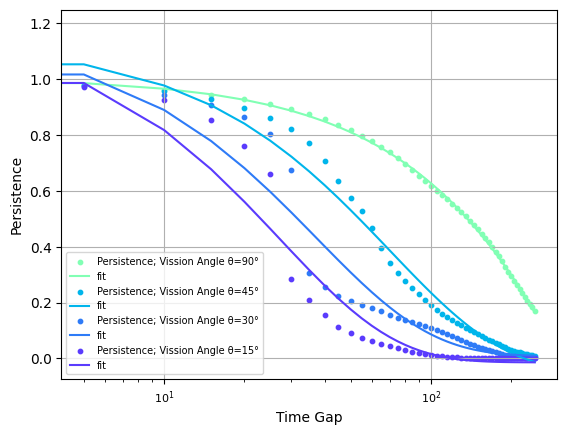

In [103]:
def main():
    # file_paths = [r"Runs\Low Density\LD10MP02/", r"Runs\Low Density\LD10MP04/", r"Runs\Low Density\LD10MP06/",  r"Runs\Low Density\LD10MP12/"]
    # file_paths = [r"Runs\Mid Density\MD1MPI2/", r"Runs\Mid Density\MD1MPI4/", r"Runs\Mid Density\MD1MPI6/",  r"Runs\Mid Density\MD1MPI12/"]
    file_paths = [r"Runs\High Density\HD1MPI02/", r"Runs\High Density\HD1MPI04/", r"Runs\High Density\HD1MPI06/",  r"Runs\High Density\HD1MPI12/"]
    thetas = [math.pi/2, math.pi/4, math.pi/6,math.pi/12]  # Replace with actual values or variables

    for file_path, theta in zip(file_paths, thetas):
        data = load_data(file_path)
        persistence_values, x = persistence(data)
        plot_persistence(x[:50], persistence_values[:50], (180/math.pi)*theta, "Plots/")

        # data = load_data(file_path)
        # x, MSD_values, MSD_std = MSD(data)
        # plot_MSD(x, MSD_values, (180/math.pi)*theta, "Plots/")
        

if __name__ == "__main__":
    main()